In [7]:
install.packages(c("quantmod", "forecast", "tseries", "urca"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘zoo’, ‘TTR’, ‘colorspace’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘RcppArmadillo’, ‘quadprog’




In [8]:
library(quantmod)
library(forecast)
library(tseries)
library(urca)

set.seed(123)
options(stringsAsFactors = FALSE)

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [9]:
# 1. Data Retrieval

start_date <- "2010-01-01"
end_date   <- "2025-11-30"
getSymbols("^GSPC", src = "yahoo",from = start_date, to = end_date)
sp500_prices <- Ad(GSPC)
colnames(sp500_prices) <- "Price"

sp500_log_price <- log(sp500_prices)
sp500_ret <- dailyReturn(sp500_prices, type = "log")
sp500_ret <- na.omit(sp500_ret)

[1] "GSPC"

In [10]:
# 2. Stationarity Tests

price_ts <- ts(as.numeric(sp500_prices), frequency = 252)
ret_ts   <- ts(as.numeric(sp500_ret),   frequency = 252)

cat("\nADF test on prices:\n")
print(adf.test(price_ts))

cat("\nKPSS test on prices:\n")
print(kpss.test(price_ts))

cat("\nADF test on log returns:\n")
print(adf.test(ret_ts))

cat("\nKPSS test on log returns:\n")
print(kpss.test(ret_ts))


ADF test on prices:

	Augmented Dickey-Fuller Test

data:  price_ts
Dickey-Fuller = -0.97676, Lag order = 15, p-value = 0.9425
alternative hypothesis: stationary


KPSS test on prices:


Warning message in kpss.test(price_ts):
“p-value smaller than printed p-value”



	KPSS Test for Level Stationarity

data:  price_ts
KPSS Level = 33.176, Truncation lag parameter = 10, p-value = 0.01


ADF test on log returns:


Warning message in adf.test(ret_ts):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  ret_ts
Dickey-Fuller = -16.521, Lag order = 15, p-value = 0.01
alternative hypothesis: stationary


KPSS test on log returns:


Warning message in kpss.test(ret_ts):
“p-value greater than printed p-value”



	KPSS Test for Level Stationarity

data:  ret_ts
KPSS Level = 0.031145, Truncation lag parameter = 10, p-value = 0.1



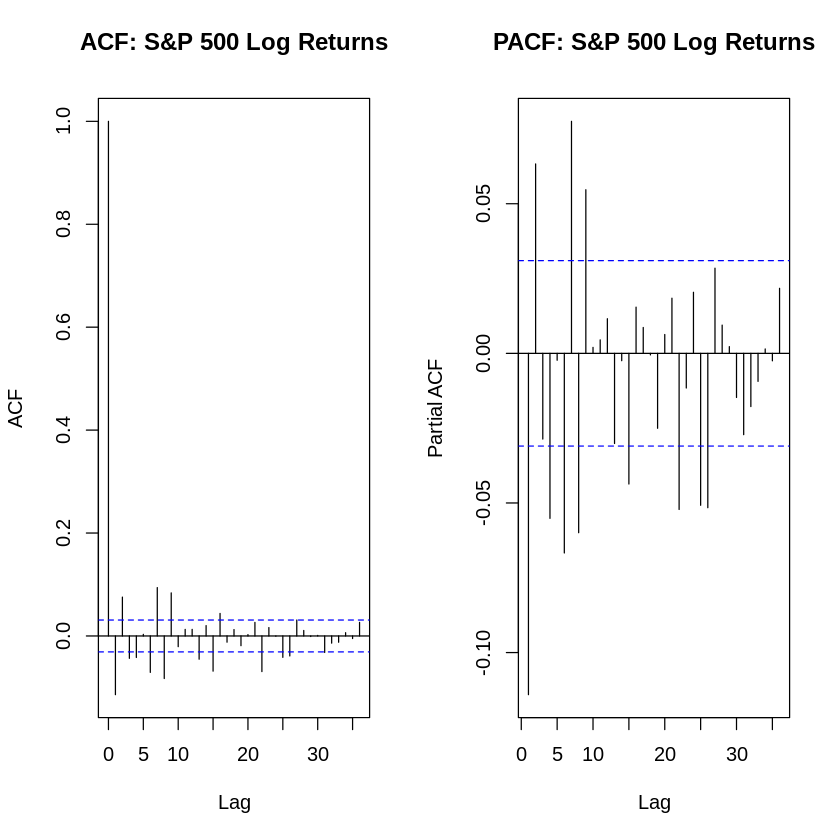

In [11]:
# 3. ACF / PACF
par(mfrow = c(1, 2))
acf(sp500_ret, main = "ACF: S&P 500 Log Returns")
pacf(sp500_ret, main = "PACF: S&P 500 Log Returns")
par(mfrow = c(1, 1))


In [12]:
# 4. ARIMA Grid Search

candidate_orders <- expand.grid(p = 0:2, d = 0, q = 0:2)
aic_vec <- bic_vec <- rep(NA, nrow(candidate_orders))

for (i in seq_len(nrow(candidate_orders))) {
  ord <- as.integer(candidate_orders[i, c("p","d","q")])
  fit <- try(Arima(sp500_ret, order = ord), silent = TRUE)
  if (!inherits(fit, "try-error")) {
    aic_vec[i] <- AIC(fit)
    bic_vec[i] <- BIC(fit)
  }
}

model_grid <- cbind(candidate_orders, AIC = aic_vec, BIC = bic_vec)

cat("\nARIMA(p,d,q) grid search on returns:\n")
print(model_grid[order(model_grid$AIC), ])


ARIMA(p,d,q) grid search on returns:
  p d q       AIC       BIC
9 2 0 2 -24894.04 -24856.27
8 1 0 2 -24827.97 -24796.50
3 2 0 0 -24827.76 -24802.58
6 2 0 1 -24826.91 -24795.44
5 1 0 1 -24825.41 -24800.23
7 0 0 2 -24824.90 -24799.73
2 1 0 0 -24813.70 -24794.82
4 0 0 1 -24807.65 -24788.76
1 0 0 0 -24763.30 -24750.71


In [13]:
# 5. Manual model: ARIMA(0,0,2)

manual_order <- c(0, 0, 2)
fit_auto   <- auto.arima(sp500_ret, seasonal = FALSE)
fit_manual <- Arima(sp500_ret, order = manual_order)

cat("\n=== FULL auto.arima summary ===\n")
print(summary(fit_auto))

cat("\n=== FULL ARIMA(0,0,2) summary ===\n")
print(summary(fit_manual))


=== FULL auto.arima summary ===
Series: sp500_ret 
ARIMA(4,0,0) with non-zero mean 

Coefficients:
          ar1     ar2      ar3      ar4   mean
      -0.1066  0.0635  -0.0344  -0.0551  4e-04
s.e.   0.0158  0.0159   0.0159   0.0158  2e-04

sigma^2 = 0.0001178:  log likelihood = 12425.62
AIC=-24839.23   AICc=-24839.21   BIC=-24801.46

Training set error measures:
                        ME       RMSE         MAE  MPE MAPE      MASE
Training set -3.534288e-07 0.01084778 0.007226306 -Inf  Inf 0.6748749
                      ACF1
Training set -0.0001524463

=== FULL ARIMA(0,0,2) summary ===
Series: sp500_ret 
ARIMA(0,0,2) with non-zero mean 

Coefficients:
          ma1     ma2   mean
      -0.1010  0.0724  4e-04
s.e.   0.0157  0.0164  2e-04

sigma^2 = 0.0001183:  log likelihood = 12416.45
AIC=-24824.9   AICc=-24824.89   BIC=-24799.73

Training set error measures:
                       ME       RMSE        MAE  MPE MAPE      MASE
Training set 6.541676e-08 0.01087267 0.00721472 -Inf  Inf


Residual diagnostics for: auto.arima (full) 

Ljung–Box test:

	Box-Ljung test

data:  res
X-squared = 92.728, df = 15, p-value = 3.064e-13


Shapiro–Wilk test:

	Shapiro-Wilk normality test

data:  sample(res, min(5000, length(res)))
W = 0.9011, p-value < 2.2e-16


Residual diagnostics for: ARIMA(0,0,2) (full) 


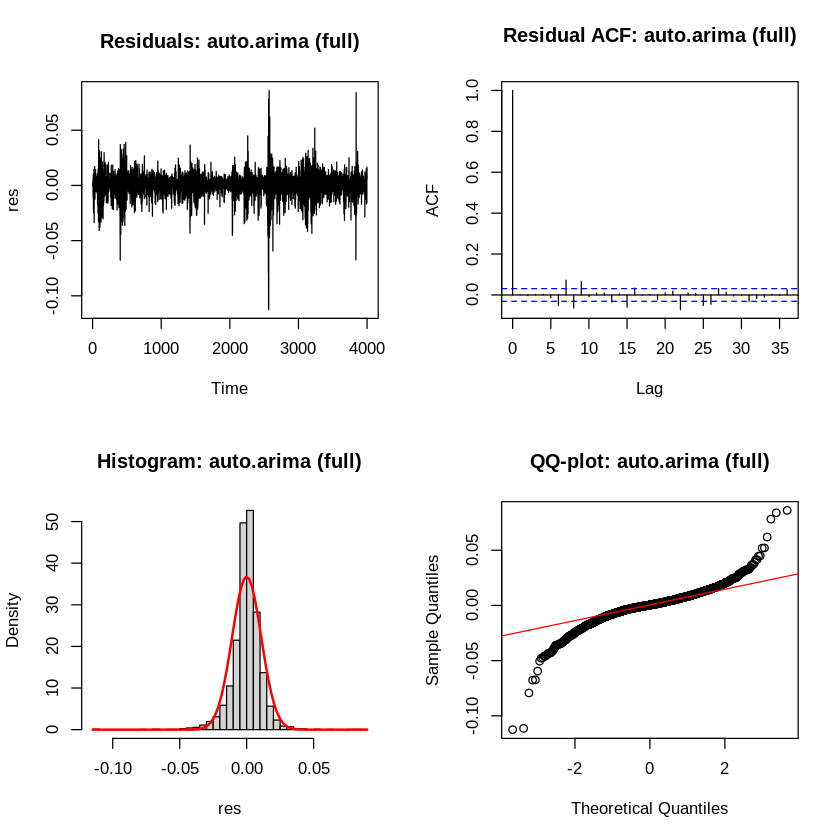


Ljung–Box test:

	Box-Ljung test

data:  res
X-squared = 118.46, df = 17, p-value < 2.2e-16


Shapiro–Wilk test:

	Shapiro-Wilk normality test

data:  sample(res, min(5000, length(res)))
W = 0.89996, p-value < 2.2e-16



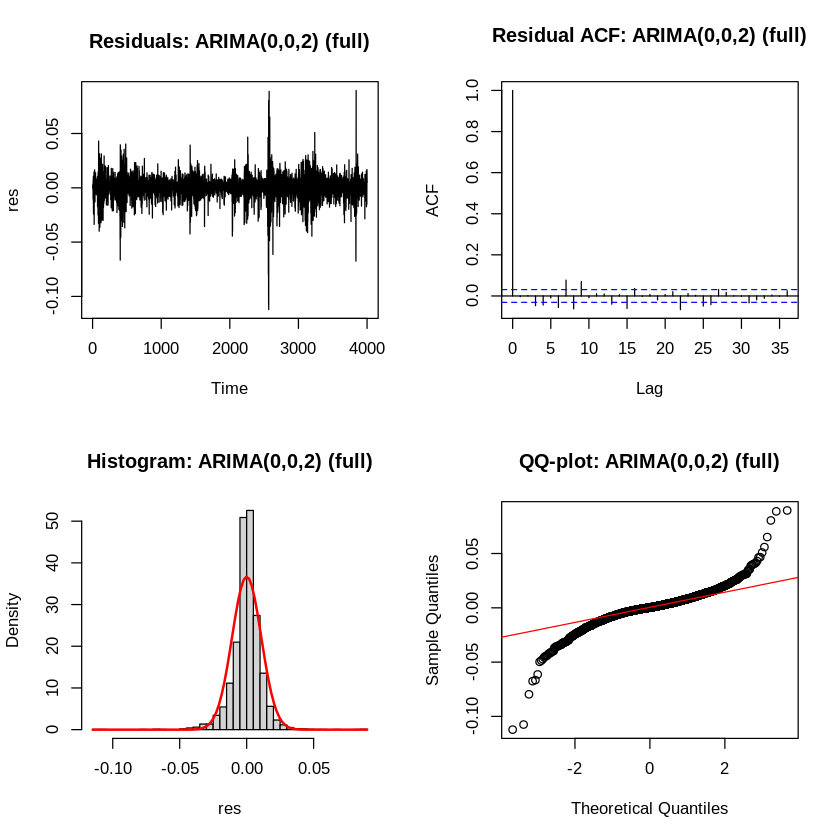

In [14]:
# 6. Residual Diagnostics

check_arima_residuals <- function(fit, model_name = "Model") {

  res <- residuals(fit)

  cat("\n===========================\n")
  cat("Residual diagnostics for:", model_name, "\n")
  cat("===========================\n")

  par(mfrow = c(2, 2))

  ts.plot(res, main = paste("Residuals:", model_name))

  acf(res, main = paste("Residual ACF:", model_name))

  hist(res, breaks = 40, probability = TRUE,
       main = paste("Histogram:", model_name))
  curve(dnorm(x, mean = mean(res), sd = sd(res)),
        add = TRUE, col = "red", lwd = 2)

  qqnorm(res, main = paste("QQ-plot:", model_name))
  qqline(res, col = "red")

  par(mfrow = c(1, 1))

  lb <- Box.test(res, type = "Ljung-Box", lag = 20,
                 fitdf = length(coef(fit)))
  cat("\nLjung–Box test:\n")
  print(lb)

  sw <- shapiro.test(sample(res, min(5000, length(res))))
  cat("\nShapiro–Wilk test:\n")
  print(sw)
}

diag_auto   <- check_arima_residuals(fit_auto,   "auto.arima (full)")
diag_manual <- check_arima_residuals(fit_manual, "ARIMA(0,0,2) (full)")

In [15]:
# 7. Train/Test Forecasting

train_end <- as.Date("2022-12-31")
sp500_ret_train <- sp500_ret[index(sp500_ret) <= train_end]
sp500_ret_test  <- sp500_ret[index(sp500_ret) >  train_end]

fit_auto_train   <- auto.arima(sp500_ret_train, seasonal = FALSE)
fit_manual_train <- Arima(sp500_ret_train, order = manual_order)

cat("\n=== TRAIN auto.arima summary ===\n")
print(summary(fit_auto_train))

cat("\n=== TRAIN ARIMA(0,0,2) summary ===\n")
print(summary(fit_manual_train))

h_test <- length(sp500_ret_test)

fc_auto_test   <- forecast(fit_auto_train,   h = h_test)
fc_manual_test <- forecast(fit_manual_train, h = h_test)

y_test      <- as.numeric(sp500_ret_test)
yhat_auto   <- as.numeric(fc_auto_test$mean)
yhat_manual <- as.numeric(fc_manual_test$mean)

err_auto   <- y_test - yhat_auto
err_manual <- y_test - yhat_manual

rmse <- function(e) sqrt(mean(e^2))
mae  <- function(e) mean(abs(e))

perf <- data.frame(
  Model = c("auto.arima", "ARIMA(0,0,2)"),
  RMSE  = c(rmse(err_auto),   rmse(err_manual)),
  MAE   = c(mae(err_auto),    mae(err_manual))
)

cat("\nOut-of-sample forecast performance:\n")
print(perf)

cat("\nDiebold–Mariano test:\n")
print(dm.test(err_auto, err_manual, h = 1, power = 2))


=== TRAIN auto.arima summary ===
Series: sp500_ret_train 
ARIMA(4,0,0) with non-zero mean 

Coefficients:
          ar1     ar2      ar3      ar4   mean
      -0.1179  0.0665  -0.0231  -0.0511  4e-04
s.e.   0.0175  0.0176   0.0176   0.0175  2e-04

sigma^2 = 0.0001239:  log likelihood = 10077.63
AIC=-20143.26   AICc=-20143.24   BIC=-20106.7

Training set error measures:
                      ME       RMSE         MAE  MPE MAPE      MASE
Training set 6.18428e-07 0.01112117 0.007358919 -Inf  Inf 0.6728137
                      ACF1
Training set -0.0001120767

=== TRAIN ARIMA(0,0,2) summary ===
Series: sp500_ret_train 
ARIMA(0,0,2) with non-zero mean 

Coefficients:
          ma1     ma2   mean
      -0.1134  0.0782  4e-04
s.e.   0.0174  0.0180  2e-04

sigma^2 = 0.0001242:  log likelihood = 10071.96
AIC=-20135.91   AICc=-20135.9   BIC=-20111.54

Training set error measures:
                       ME      RMSE         MAE  MPE MAPE      MASE        ACF1
Training set 3.272501e-07 0.0111405 

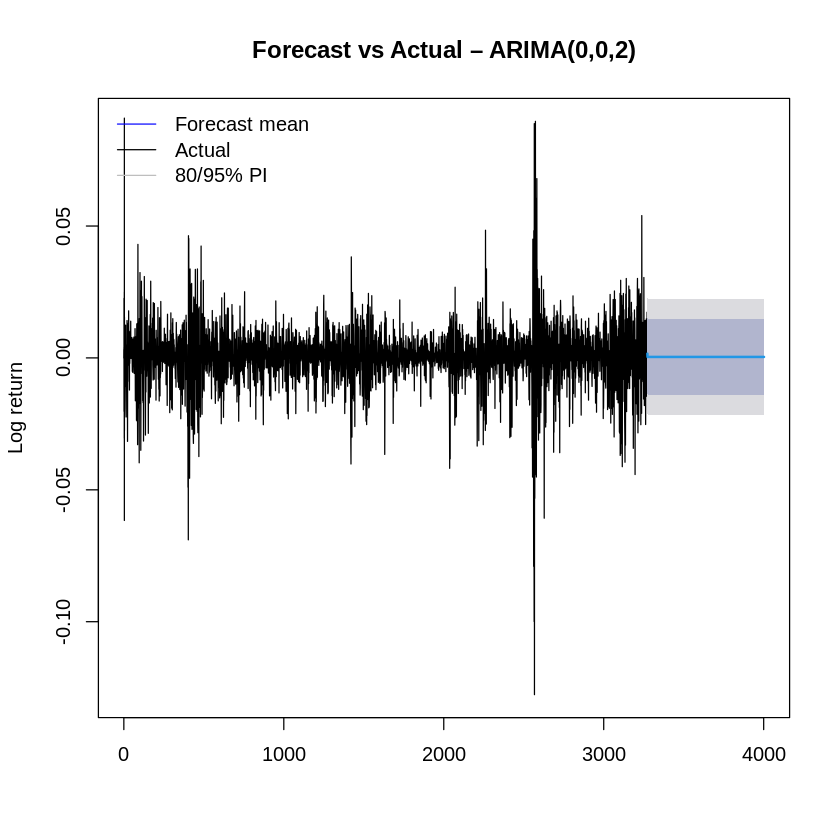

In [16]:
# 8. Forecast Plot

preferred_fc  <- fc_manual_test
preferred_fit <- fit_manual_train
preferred_name <- "ARIMA(0,0,2)"

ts_test <- ts(y_test, frequency = 252)

plot(preferred_fc,
     main = paste("Forecast vs Actual –", preferred_name),
     ylab = "Log return")
lines(ts_test, col = "black", lwd = 1)
legend("topleft",
       legend = c("Forecast mean", "Actual", "80/95% PI"),
       col = c("blue", "black", "grey"),
       lty = 1, bty = "n")